In [1]:
# !pip install imdbpy

In [2]:
import pandas as pd
import numpy as np
from imdb import IMDb

from pprint import pprint
from IPython.display import display, HTML, Markdown

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
from tqdm.notebook import tqdm, trange


reload_imdb = True # If need to re-run IMDb Loop
filename = 'imdb_data.pkl' # Where to save IMDb data
sns.set_style('whitegrid')

In [3]:
def print_markdown(text):
    display(Markdown(text))

# Netflix data

In [5]:
df = pd.read_csv('ViewingActivity.csv')

In [6]:
# Start Time - UTC
df.head()

,Profile Name,Start Time,Duration,Attributes,Title,Supplemental Video Type,Device Type,Bookmark,Latest Bookmark,Country
0,Home,2021-03-26 19:51:53,00:06:26,NaN,Bridgerton: Season 1: Swish (Episode 6),NaN,Apple TV 4K,00:15:57,00:15:57,KZ (Kazakhstan)
1,Home,2021-03-26 19:08:29,00:41:41,Autoplayed: user action: None;,The One: Season 1: Episode 8,NaN,Apple TV 4K,00:41:51,00:41:51,KZ (Kazakhstan)
2,Home,2021-03-26 18:26:54,00:40:44,Autoplayed: user action: None;,The One: Season 1: Episode 7,NaN,Apple TV 4K,00:40:49,00:40:49,KZ (Kazakhstan)
3,Home,2021-03-26 17:45:02,00:37:05,Autoplayed: user action: None;,The One: Season 1: Episode 6,NaN,Apple TV 4K,00:37:13,00:37:13,KZ (Kazakhstan)
4,Home,2021-03-26 17:12:29,00:32:09,NaN,The One: Season 1: Episode 5,NaN,Apple TV 4K,00:40:09,00:40:09,KZ (Kazakhstan)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091 entries, 0 to 1090
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Profile Name             1091 non-null   object
 1   Start Time               1091 non-null   object
 2   Duration                 1091 non-null   object
 3   Attributes               306 non-null    object
 4   Title                    1091 non-null   object
 5   Supplemental Video Type  163 non-null    object
 6   Device Type              1091 non-null   object
 7   Bookmark                 1091 non-null   object
 8   Latest Bookmark          1091 non-null   object
 9   Country                  1091 non-null   object
dtypes: object(10)
memory usage: 85.4+ KB


In [8]:
df_clean = (
    df
    .rename(columns=lambda x: x.lower().replace(' ', '_')) # Normalize column names
    .loc[lambda x: x['supplemental_video_type'].isnull()] # Remove supplementals (trailers, teasers, etc)
    .assign(
        start_time     = lambda x: pd.to_datetime(x['start_time']),
        start_time_kz  = lambda x: x['start_time'] + pd.DateOffset(hours=6), # Convert to UTC +6 (Kazakhstan, Almaty)
        duration       = lambda x: pd.to_datetime(x['duration'], format='%H:%M:%S'),
        duration_hours = lambda x: x['duration'].dt.hour + x['duration'].dt.minute / 60,
        title_clean    = lambda x: x['title'].str.replace(': (?i)(part|season|volume|limited series|series|chapter)(.*)', '').str.strip(),
        start_date     = lambda x: x['start_time_kz'].dt.date,
        start_hour     = lambda x: x['start_time_kz'].dt.hour,
        is_holiday     = lambda x: x['start_time_kz'].dt.weekday >= 5,
    )
    [['profile_name', 'start_time_kz', 'is_holiday', 'start_date', 'start_hour', 'duration_hours', 'title', 'title_clean']]
)

df_clean.sample(5)

,profile_name,start_time_kz,is_holiday,start_date,start_hour,duration_hours,title,title_clean
139,Home,2020-09-01 14:06:23,False,2020-09-01,14,0.166667,"Anne with an E: Season 1: I Am No Bird, and No...",Anne with an E
935,Family,2018-10-08 21:49:17,False,2018-10-08,21,0.016667,The Amazing Spider-Man 2,The Amazing Spider-Man 2
318,Home,2019-11-03 21:02:11,True,2019-11-03,21,0.433333,Insatiable: Season 2: Poison Patty (Episode 4),Insatiable
195,Home,2020-03-26 21:44:20,False,2020-03-26,21,0.583333,Locke & Key: Season 1: Crown of Shadows (Episo...,Locke & Key
847,Family,2019-03-26 20:10:47,False,2019-03-26,20,0.900000,The Umbrella Academy: Season 1: Extra Ordinary...,The Umbrella Academy


# IMDB

In [9]:
ia = IMDb()

In [10]:
def get_movie_info(movie_title):
    '''
    Returns a dict with movie metadata based on Movie title
    '''
    search_result = ia.search_movie(movie_title)
    
    if search_result:
        movie_id = search_result[0].getID()
        movie = ia.get_movie(movie_id)

        return {
            'netflix_title': movie_title,
            'imdb_title'   : movie['title'] if 'title' in movie else None,
            'year'         : movie['year'] if 'year' in movie else None,
            'genre'        : movie['genres'] if 'genres' in movie else None,
            'country'      : movie['countries'] if 'countries' in movie else None
        }
    print(f'{movie_title} not found')

In [11]:
r = get_movie_info('The One')

In [12]:
pprint(r)

{'country': ['United Kingdom'],
 'genre': ['Crime', 'Drama', 'Sci-Fi', 'Thriller'],
 'imdb_title': 'The One',
 'netflix_title': 'The One',
 'year': 2021}


## Loop for all the movies

In [13]:
title_list = df_clean['title_clean'].unique().tolist()
print(f'{len(title_list)} movies')

259 movies


In [14]:
%%time

if reload_imdb:

    imdb_list = []

    for i in trange(len(title_list)):
        title = title_list[i]
        print(title)
        r = get_movie_info(title)
        
        if r:
            imdb_list.append(r)
        
    f = open(filename, 'wb')
    pickle.dump(imdb_list, f)
    f.close()

else:
    imdb_list = pd.read_pickle(filename)

Wall time: 8.1 ms


# Merge

In [15]:
df_imdb = pd.DataFrame(imdb_list)
df_imdb.sample(3)

,netflix_title,imdb_title,year,genre,country
137,Trinkets,Trinkets,2019,"[Comedy, Crime, Drama]",[United States]
220,Rango,Rango,2011,"[Animation, Adventure, Comedy, Family, Western]","[United States, Canada]"
75,The Terminal,The Terminal,2004,"[Comedy, Drama, Romance]",[United States]


In [16]:
df_merged = (
    df_clean
    .merge(
        df_imdb,
        how='left',
        left_on='title_clean',
        right_on='netflix_title'
    )
)

df_merged.sample(3)

,profile_name,start_time_kz,is_holiday,start_date,start_hour,duration_hours,title,title_clean,netflix_title,imdb_title,year,genre,country
478,Family,2020-10-11 19:33:19,True,2020-10-11,19,0.866667,The Haunting of Bly Manor: Season 1: The Two F...,The Haunting of Bly Manor,The Haunting of Bly Manor,The Haunting of Bly Manor,2020.0,"[Drama, Horror, Mystery, Thriller]",[United States]
325,Home,2019-09-05 16:55:08,False,2019-09-05,16,0.666667,"13 Reasons Why: Season 1: Tape 1, Side A (Epis...",13 Reasons Why,13 Reasons Why,13 Reasons Why,2017.0,"[Drama, Mystery, Thriller]",[United States]
342,Home,2019-08-25 09:13:35,True,2019-08-25,9,0.000000,RuPaul's Drag Race: Season 1: Absolut Drag Bal...,RuPaul's Drag Race,RuPaul's Drag Race,RuPaul's Drag Race,2009.0,"[Game-Show, Reality-TV]",[United States]


# Analysis

In [17]:
profile_names = df_merged.profile_name.unique()

chosen_palette = 'colorblind'
colors = sns.color_palette(chosen_palette)
sns.set_palette(chosen_palette)

In [18]:
def make_summary(df):
    return (
        df
        .rename(
            columns={
                'profile_name': 'Profile',
            }
        )
        .groupby('Profile')
        .agg(
            sessions = ('start_time_kz', 'count'),
            freq_hour = ('start_hour', pd.Series.mode),
            total_duration = ('duration_hours', 'sum'),
            days = ('start_date', 'nunique')
        )
        .assign(
            hours_per_day = lambda x: x['total_duration'] / x['days']
        )
        .rename(
            columns={
                'sessions': 'Sessions',
                'freq_hour': 'Most Frequent Hour',
                'total_duration': 'Total Hours',
                'days': 'Days',
                'hours_per_day': 'Hours per Day'
            }
        )
        .style.format({
            'Total Hours': '{:.0f}',
            'Hours per Day': '{:.2f}'
        })
    )

def make_top(df, column, top_size=5):
    df_top_5 = (
        df
        .explode(column)
        .groupby(['profile_name', column])
        .agg(
            n_movies = ('title_clean', 'nunique')
        )
        .sort_values(by=['profile_name', 'n_movies'], ascending=[True, False])
        .reset_index()
        .groupby('profile_name')
        .head(top_size)
        .rename(columns={'n_movies': '# Movies'})
    )   

    for i in range(len(profile_names)):
        profile_name = profile_names[i]
        
        plt.figure(figsize=(7, 4))

        sns.barplot(
            data=df_top_5.loc[lambda x: x['profile_name'] == profile_name], 
            x=column, 
            y='# Movies',  
            color=colors[i],
            saturation=1
        )
        plt.title(f"{profile_name}")
        plt.legend([],[], frameon=False)
        plt.ylim(0, np.ceil(df_top_5['# Movies'].max() / 10) * 10)
        plt.xlabel('')
        
        for spine in plt.gca().spines.values():
            spine.set_visible(False)
            
        plt.savefig(f'{column}_{profile_name}.png', dpi=200)
        plt.show()
        
def analyze_hours(df, y_lim):
    
    for is_holiday in [False, True]: 
    
        titles = {True: 'Weekend', False: 'Workdays'}
        
        plt.figure(figsize=(7, 4))

        sns.kdeplot(
            data=df.loc[lambda x: x['is_holiday'] == is_holiday], 
            x='start_hour', 
            hue='profile_name'
        )

        plt.title(f"{titles[is_holiday]}")
        plt.legend([],[], frameon=False)
        plt.xlabel('Start Hour')
        plt.grid(b=False, which='both', axis='x')
        plt.ylim(0, y_lim)
        
        for spine in plt.gca().spines.values():
            spine.set_visible(False)
        
        plt.savefig(f'hours_{titles[is_holiday]}.png', dpi=200)
        plt.show()

## Summary statistics

In [19]:
make_summary(df_merged)

,Sessions,Most Frequent Hour,Total Hours,Days,Hours per Day
Profile,,,,,
Family,515,20,212,236,0.90
Home,413,21,184,122,1.51


## Genres

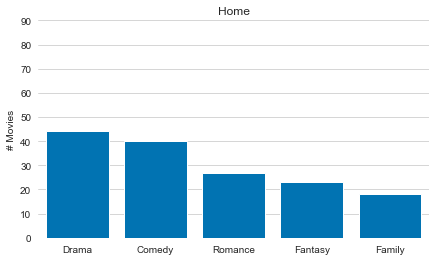

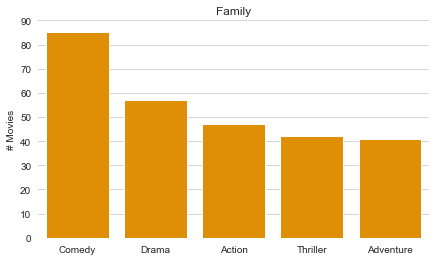

In [20]:
colname = 'genre'
make_top(df_merged, colname)

## Countries

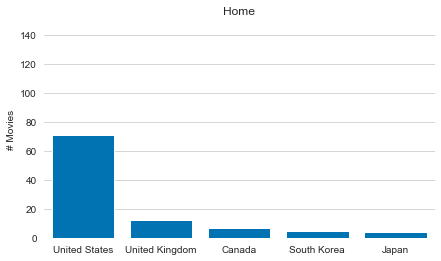

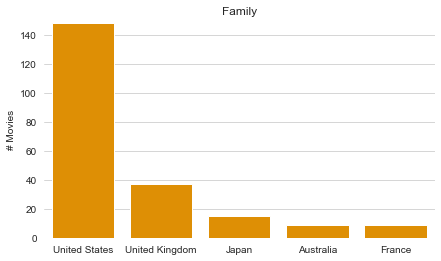

In [21]:
colname = 'country'
make_top(df_merged, colname)

## Hours

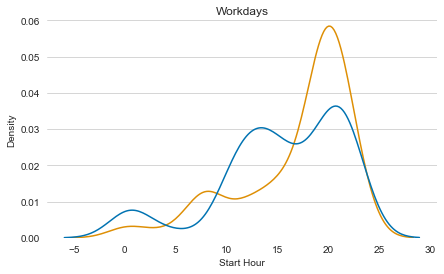

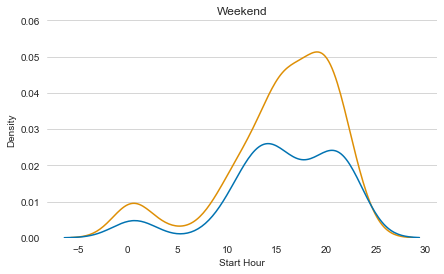

In [22]:
analyze_hours(df_merged, y_lim=0.06)